# NLP Classifier

_from Jurafsky & Martin 3rd edition, ch. 4_

Classifiers are at the heart of many, if not all, NLP tasks. Whether it's sentiment analysis, spam detection, document classification, authorship attribution or something else, we're likely to use Classifiers for our model.

Most of modern classifiers are **supervised** algorithms that try to learn the conditional probability 

$$P(class|input)$$

given a training set of inputs already provided with a *supervision signal* (a label specifying the correct classification).

Some models are **Probabilistic classifiers** in the sense that they return probabilities that a given input belongs to a class.

In general we have two kinds of classifiers:

- **Generative classifiers**: like the one explored here, the Naive Bayes Classifier, that try to build a model of how a class could be generated given an input.
- **Discriminative classifiers**: like the Logistic Regression model, try to learrn what features are good indicators for a given class.

## Multinomial Naive Bayes

Naive Bayes is a probabilistic classifier, meaning that for a document d, out of all classes c 2 C the classifier returns the class $\hat{c}$ which has the maximum posterior probability given the document. 

$$\hat{c} = argmax_{c \in C} P(c|d)$$

where $\hat{c}$ is the predicted class, $C$ the set of possible classes and $P(c|d)$ is the probability of assigning a class c given a document $d$.

Using *Bayes theorem* we can rewrite the formula above into:

$$\hat{c} = argmax_{c \in C} P(d|c)P(c)$$

Here $P(c)$ is the prior-probability for a given class and $P(d|c)$ is the likelihood. We can represent the document as a set of features.

#### Simplyfiying assumption

+ $P(d|c)$ in the formula above is too complicated to be calculated if we want to retain all the features (words, word-positions etc..). The first simplification is thus to use a BOW-representation, where only the words and their frequencies are taken into consideration.

+ The second assumption is the *Naive Bayes assumption*: conditional independence of features. We assume that the vectors used to represent the words in a text are independent of each other and can thus be *naively* multiplied.

$$P(f_1, f_2, ... f_n|c) = P(f_1|c) \times P(f_2|c) \times ... P(f_n|c)  $$

or more concisely:

$$\hat{c} = argmax_{c \in C} \prod_{f \in F} P(f|c)$$

The computations are done in log space, to increase speed and avoid underflow:

$$\hat{c} = argmax_{c \in C} \log P(c) + \sum_{i \in N} \log P(w_i|c)$$

How do we calculate the two member of the preceding equation?

+ **$P(c)$**:

For this we can use the Maximum Likehood Estimator:

$$P(c) = \frac{N_c}{N_d}$$

+ **$P(w_i|c)$**:

In our case the "feature" we're interested in is just the existence of a given word in a document with a given classification; Thus we can compute this probability as:

$$P(w_i|c) = \frac{Count(w_i, c)}{\sum_{w \in V} Count(w,c)}$$

where $V$ is the vocabulary, the union of all word types in all classes not just the words in one class c.

This probabilities are adjusted with the **Laplace smoothing**:

$$P(w_i|c) = \frac{Count(w_i, c) + 1}{(\sum_{w \in V} Count(w,c)) + |V|}$$

# Implementation

The data were taken from [Kaggle/datatattle](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)

In [1]:
import nltk
from nltk.tokenize import TweetTokenizer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
from tqdm.notebook import tqdm

In [2]:
from collections import defaultdict, Counter
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

## Data loading and exploratory analysis

In [3]:
# Load training data
data = pd.read_csv("Corona_NLP_train.csv")

In [4]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
# Show how many observations the dataset contain
data.shape

(41157, 6)

In [6]:
# Show counts by Sentiment
data['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

[Text(0, 0, 'Neutral'),
 Text(1, 0, 'Positive'),
 Text(2, 0, 'Extremely Negative'),
 Text(3, 0, 'Negative'),
 Text(4, 0, 'Extremely Positive')]

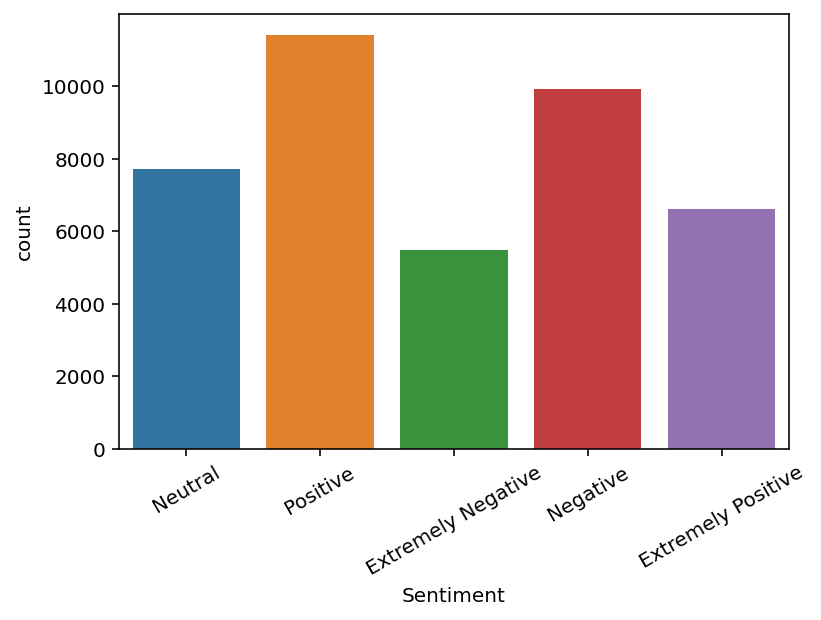

In [7]:
plot = sns.countplot(x="Sentiment", data=data)
plot.set_xticklabels(plot.get_xticklabels(),rotation=30)

## Train Naive Bayes

In [8]:
class Data(object):
    """
    Extract data (tweets and sentiment labels) from the dataset
    and organize the data for later use.
    
    """
    def __init__(self, data):
        self.df = data # the pandas dataframe
        self.tweets = data['OriginalTweet'].tolist()
    
        self.classes = data['Sentiment'].unique().tolist()
        self.mappings = self.class_dictionary()
        
        self.tokens = self.tokenize() # needed to build the vocab
        self.vocab = self.build_vocab()
        
        # Subsetting
        self.tweets_per_class = self.split_tweets()
        
    def class_dictionary(self):
        """
        Mapping sentiment label : unique id
        """
        mappings = dict()
        for i, c in enumerate(self.classes):
            mappings[c] = i
        return mappings
        
    def tokenize(self):
        tokens = [tokenizer.tokenize(tweet) for tweet in tqdm(self.tweets)]
        tokens = self.flatten_list(tokens)
        tokens = self.clean_tokens(tokens)
        return tokens
    
    def build_vocab(self):
        unique_tokens = set(self.tokens)
        vocab = dict()
        for word in unique_tokens:
            if word not in vocab:
                vocab[word] = len(vocab)
        # Add unknown
        vocab['UNK'] = len(vocab)
        return vocab
    
    def split_tweets(self):
        """
        return: a dictionary where the sentiment labels are the keys and the values are flatten lists of tokenized tweets
        """
        subsets = defaultdict(list)
        for c in tqdm(self.classes, desc="Creating subsets"):
            tweets = self.df[self.df['Sentiment'] == c]['OriginalTweet'].tolist()
            print(f"Class{c} contains {len(tweets)} tweets")
            tokens = [tokenizer.tokenize(sent) for sent in tweets]
            tokens = self.flatten_list(tokens)
            subsets[c] = tokens
        return subsets
    
    @staticmethod
    def flatten_list(tokens):
        tokens = [w for tweet in tokens for w in tweet]
        return tokens
    
    @staticmethod
    def clean_tokens(tokens):
        """
        Eliminate noise
        
        """
        tokens = [w for w in tokens if not w.startswith('https')]
        tokens = [w for w in tokens if not w.startswith('http')]
        tokens = [w for w in tokens if not w.startswith('#')]
        tokens = [w.lower() for w in tokens]
        return tokens
    
    def __len__(self):
        return len(self.tweets)
        

In [9]:
data = Data(data)

  0%|          | 0/41157 [00:00<?, ?it/s]

Creating subsets:   0%|          | 0/5 [00:00<?, ?it/s]

ClassNeutral contains 7713 tweets
ClassPositive contains 11422 tweets
ClassExtremely Negative contains 5481 tweets
ClassNegative contains 9917 tweets
ClassExtremely Positive contains 6624 tweets


In [10]:
class NBayes(object):
    """
    Training class for the Classifiers
    
    """
    def __init__(self, data):
    
        self._data = data # The data class
        self.vocab = self._data.vocab #the vocabulary with all words in all training tweets
        self.subsets = self._data.tweets_per_class # subset by sentiment
        self.mappings = self._data.mappings # mapping sentiment : idx
        
        # Calculate prior probabilities for each class
        self.priors = defaultdict(float)
        self.calc_prior()
        
        # P(w|c) likelihood for each word, in each class
        # Numpy array (classes, vocab) = (5,37865)
        self.likelihood = self.calc_likelihood()
    
    def calc_prior(self):
        """
        Calculate the a priori probabilities for each sentiment class
        """
        for c in self.mappings.keys():
            # Number of tweet per class
            N_c = self._data.df['Sentiment'].value_counts()[c]
            # Number of all tweets 
            N_d = len(self._data)
            self.priors[c] = np.log(N_c/N_d)
            print(f"Class {c} has prior = {self.priors[c]}")
        
    def calc_likelihood(self):
        """
        Core training function
        
        """
        likelihood = np.zeros((len(self.subsets), len(self.vocab)))
        for c, tweets in tqdm(self.subsets.items(), desc="Class Likelihood"):
            word_likelihood = sum(Counter(tweets).values()) + len(self.vocab)
            counter = Counter(tweets)
            for word in tqdm(self.vocab, desc="Word likelihood"):
                count = counter[word] +1 
                likelihood[self.mappings[c], self.vocab[word]] = np.log(count/ word_likelihood)
        return likelihood                   

In [11]:
classifier_train = NBayes(data=data)

Class Neutral has prior = -1.6744868050602755
Class Positive has prior = -1.2818527017694663
Class Extremely Negative has prior = -2.016106455948158
Class Negative has prior = -1.4231435658081495
Class Extremely Positive has prior = -1.826694604929179


Class Likelihood:   0%|          | 0/5 [00:00<?, ?it/s]

Word likelihood:   0%|          | 0/37865 [00:00<?, ?it/s]

Word likelihood:   0%|          | 0/37865 [00:00<?, ?it/s]

Word likelihood:   0%|          | 0/37865 [00:00<?, ?it/s]

Word likelihood:   0%|          | 0/37865 [00:00<?, ?it/s]

Word likelihood:   0%|          | 0/37865 [00:00<?, ?it/s]

In [12]:
import random

In [25]:
class TestBayes(object):
    def __init__(self, trained_classifier):
        
        self.priors = trained_classifier.priors
        self.vocab = trained_classifier.vocab
        self.classes = list(trained_classifier.subsets.keys())
        self.mappings = trained_classifier.mappings
        self.likelihood = trained_classifier.likelihood # np array
        
        self.test_data = self.load_test_data()
    
    @staticmethod
    def load_test_data():
        test_df = pd.read_csv("Corona_NLP_test.csv")
        return test_df
    
    def __len__(self):
        return len(self.test_data)
        
    
    def choose_random(self, verbose=True):
        test_tweet = self.test_data.iloc[random.randint(0,self.test_data.shape[0]-1)]
        test_text = test_tweet['OriginalTweet']
        true_class = test_tweet['Sentiment']
        if verbose:
            print("#"*20)
            print("Random tweet")
            print("#"*20)
            print(f"Tweet chosen: {test_text}\n\n\nwith label {true_class}")
        return test_text, true_class
    
    @staticmethod
    def tokenize_tweet(tweet):
        return tokenizer.tokenize(tweet)
    
    def test_random(self,verbose=True):
        tweet, true_pred = self.choose_random(verbose=verbose)
        tweet = self.tokenize_tweet(tweet)
        classification = self.classify(tweet, true_pred, verbose=verbose)
        return classification
    
    def classify(self, tweet, true_pred, verbose=True):
        prob_vector = np.zeros(len(self.classes))
        for c, i in self.mappings.items():
            likelihood = 0
            for w in tweet:
                # Just ignore out of vocabulary words
                if w in self.vocab:
                    # Likelihood P(w_i|c)
                    likelihood += self.likelihood[i,self.vocab[w]]
            prob_vector[i] = self.priors[c] + likelihood
        predicted_class = np.argmax(prob_vector)
        if verbose:
            print("#"*20)
            print("RESULT")
            print("#"*20)
            print(f"The tweet has been classified as {self.classes[predicted_class]} -- True Class: {true_pred}")
            print(f"Correctly predicted: {self.classes[predicted_class] == true_pred}")
        return self.classes[predicted_class] == true_pred
        
    
    def shuffle(self, fraction=.2):
        return self.test_data.sample(frac=fraction)
        
    def accuracy(self, fraction=.2,verbose=False):
        data = self.shuffle(fraction=fraction)
        n = data.shape[0]
        answers = np.zeros(n)
        for i in tqdm(range(n), desc="Testing accuracy"):
            tweet = data.iloc[i]['OriginalTweet']
            true_pred = data.iloc[i]['Sentiment']
            if self.classify(tweet, true_pred, verbose=verbose):
                answers[i] = 1
        if verbose:
            print(f"Tweets tested: {n} -- Accuracy: {np.sum(answers)/n * 100}%")
        return np.sum(answers)/n * 100
        

In [26]:
tester = TestBayes(classifier_train)

In [27]:
for i, c in enumerate(tester.classes):
    print(i,c)

0 Neutral
1 Positive
2 Extremely Negative
3 Negative
4 Extremely Positive


In [30]:
tester.test_random(verbose=True)

####################
Random tweet
####################
Tweet chosen: I understand this is a stressful &amp; uncertain time for people in L.A. &amp; all over the world as we respond to COVID-19 &amp; work to keep our communities safe. We're hearing reports of misinformation. Please stick to trusted news sources &amp; gov agencies such as @LAPublicHealth &amp; @CDCgov.


with label Positive
####################
RESULT
####################
The tweet has been classified as Positive -- True Class: Positive
Correctly predicted: True


True

# Accuracy measurement

In [31]:
def accuracy(n_iter = 1, frac_dataset = 0.7):
    accuracy_values = []
    for i in range(n_iter):
        accuracy_values.append(tester.accuracy(fraction=frac_dataset))
    idx = [i for i in range(len(accuracy_values))]
    sns.lineplot(y=accuracy_values, x=idx)

Testing accuracy:   0%|          | 0/1899 [00:00<?, ?it/s]

Testing accuracy:   0%|          | 0/1899 [00:00<?, ?it/s]

Testing accuracy:   0%|          | 0/1899 [00:00<?, ?it/s]

Testing accuracy:   0%|          | 0/1899 [00:00<?, ?it/s]

Testing accuracy:   0%|          | 0/1899 [00:00<?, ?it/s]

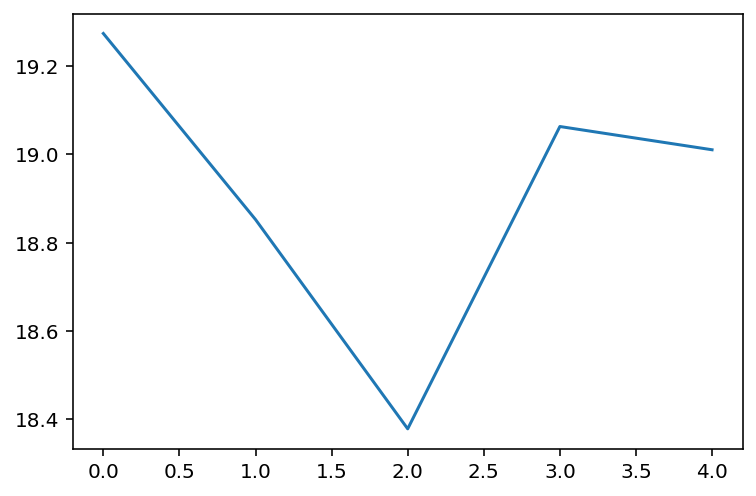

In [34]:
accuracy(n_iter=5, frac_dataset=.5)